In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#출력 그림 크기 조절
sns.set(rc={'figure.figsize':(12,12)})
plt.style.use('ggplot')
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

# for "5. Modeling with CatBoostRegressor"
from catboost import CatBoostRegressor
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold

In [2]:
# 데이터 로드
train = pd.read_csv('data/train0730.csv',index_col= False)
test = pd.read_csv('data/test0730.csv',index_col= False)

In [3]:
train = train.set_index("단지코드")
test = test.set_index("단지코드")

In [4]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

In [5]:
scailing_features = ['총세대수',
                     '지역',
                     '공가수',
                     '지하철',
                     '버스',
                     '단지내주차면수',
                     '총임대가구수',
                     '단지임대보증금',
                     '단지임대료'
                    ]

scaler = MinMaxScaler()
train.loc[:, scailing_features] = scaler.fit_transform(train[scailing_features])
test.loc[:, scailing_features] = scaler.transform(test[scailing_features])

In [6]:
train.head()

,등록차량수,총세대수,지역,공가수,지하철,버스,단지내주차면수,총임대가구수,단지임대보증금,단지임대료,...,공급_공공분양,공급_공공임대(10년),공급_공공임대(50년),공급_공공임대(5년),공급_공공임대(분납),공급_국민임대,공급_영구임대,공급_임대상가,공급_장기전세,공급_행복주택
단지코드,,,,,,,,,,,,,,,,,,,,,
C2515,205.0,0.204170,0.133333,0.309091,0.000000,0.15,0.342297,0.204170,0.167147,0.190456,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1407,1064.0,0.468135,0.400000,0.236364,0.333333,0.05,0.712605,0.468135,0.328734,0.272903,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1945,730.0,0.286782,0.066667,0.109091,0.333333,0.15,0.403922,0.286782,0.267336,0.298868,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1470,553.0,0.263572,0.800000,0.254545,0.000000,0.10,0.354062,0.263572,0.230954,0.200053,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1898,415.0,0.212431,0.800000,0.163636,0.000000,0.30,0.282353,0.212431,0.209269,0.190738,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Modeling with Gradient Boosting Regressor

- Setting Data For Model

In [7]:
X = train.drop(columns = ['등록차량수'])
y = train['등록차량수']

- Hyper params Tuning

In [8]:
def objective(trial: Trial) -> float:
    params_cat = {
        "random_state": 42,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "verbose" : 1,
        "objective" : "MAE",
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2)

    model = CatBoostRegressor(**params_cat)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False,
    )

    cat_pred = model.predict(X_val)
    log_score = mean_absolute_error(y_val, cat_pred)
    
    return log_score

In [9]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="cat_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

In [10]:
cat_p = study.best_trial.params
cat = CatBoostRegressor(**cat_p)

- StratifiedK-Fold for Regression

In [11]:
y_cat = pd.cut(y, 10, labels=range(10))
skf = StratifiedKFold(5)

preds = []
for tr_id, val_id in skf.split(X, y_cat) : 
    X_tr = X.iloc[tr_id]
    y_tr = y.iloc[tr_id]
    
    cat.fit(X_tr, y_tr, verbose = 0)
    
    pred = cat.predict(test)
    preds.append(pred)
cat_pred = np.mean(preds, axis = 0)

In [12]:
sample = pd.read_csv('data/sample_submission.csv')
sample['num'] = cat_pred
sample

,code,num
0,C1072,794.577098
1,C1128,1216.516486
2,C1456,535.323127
3,C1840,489.308314
4,C1332,1169.039914
...,...,...
145,C2456,234.273545
146,C1266,442.745364
147,C2152,-8.523226
148,C1267,366.366171


In [13]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

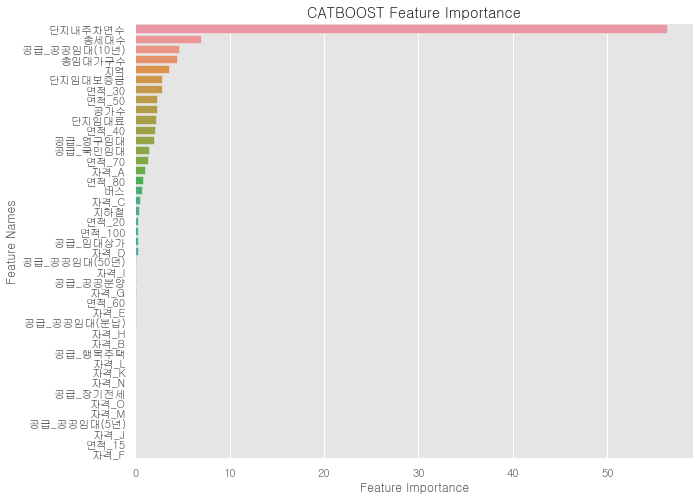

In [14]:
plot_feature_importance(cat.get_feature_importance(),test.columns,'CATBOOST')

In [15]:
sample.to_csv('sub/final_0730_1.csv', index=False)

In [16]:
# for "4. Modeling with Pycaret"
from pycaret.regression import *
X_train = train


In [20]:
reg = setup(X_train, 
            preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
            train_size = 0.999,  # 우리는 전체 데이터를 학습해 test를 예측하는게 목표이기 때문에, 0.999로 설정한다.
            target = '등록차량수', # 목표 변수는 등록 차량 수 이다.
            silent = True, # 엔터를 누르기 귀찮다. 궁금하면 풀어보세요
            use_gpu = False, # GPU가 있으면 사용하세요 (Cat BOost 속도 향상)
            numeric_features=list(X_train.drop(columns = ['등록차량수']).columns), # 모든 변수가 숫자로써의 의미가 있다.
            session_id = 2021,
            fold_shuffle = True
            )

,Description,Value
0,session_id,2021
1,Target,등록차량수
2,Original Data,"(411, 44)"
3,Missing Values,False
4,Numeric Features,43
5,Categorical Features,0
6,Transformed Train Set,"(410, 43)"
7,Transformed Test Set,"(1, 43)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


- Top5의 모델 선택

In [21]:
top5 = compare_models(n_select = 5, sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,121.0581,35506.5572,184.1725,0.7637,0.4022,0.3679,0.9880
et,Extra Trees Regressor,121.1345,34282.7508,181.5323,0.7666,0.3613,0.3183,0.0540
lasso,Lasso Regression,121.6473,31605.9489,174.7299,0.7807,0.3899,0.3427,0.0050
huber,Huber Regressor,122.1159,31426.5236,174.2433,0.7810,0.4151,0.3530,0.0090
llar,Lasso Least Angle Regression,122.4120,32895.7136,178.1427,0.7751,0.3879,0.3643,0.4270
br,Bayesian Ridge,123.5030,32170.4637,176.7460,0.7725,0.4766,0.3734,0.0060
gbr,Gradient Boosting Regressor,124.1122,34351.3810,182.4519,0.7642,0.3971,0.3423,0.0250
ridge,Ridge Regression,124.1503,32726.9532,178.2494,0.7690,0.5754,0.3858,0.0050
rf,Random Forest Regressor,124.5997,35739.0809,185.2690,0.7557,0.3696,0.3285,0.0650
par,Passive Aggressive Regressor,125.4241,34601.6266,182.6602,0.7553,0.4690,0.3902,0.0060


- Top5 Model Tuning

In [22]:
models = []
for m in top5:
    models.append(tune_model(m, 
                             optimize = 'MAE', 
                             choose_better = True,
                            n_iter = 30))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,97.0539,18152.0525,134.7296,0.8369,0.3500,0.2927
1,86.6940,13845.3986,117.6665,0.8972,0.2735,0.2195
2,115.5227,23892.0200,154.5704,0.8619,0.3780,0.3021
3,132.3330,39012.3735,197.5155,0.7240,0.3489,0.2969
4,142.0595,39993.4254,199.9836,0.7607,0.5971,0.5708
5,129.2545,24956.9351,157.9776,0.7396,0.3362,0.2976
6,127.5610,52795.9989,229.7738,0.7919,0.5309,0.5069
7,135.4253,35402.7343,188.1561,0.7381,0.2762,0.2346
8,119.4015,27149.2433,164.7703,0.6888,0.3720,0.3719
9,131.1420,40825.0312,202.0521,0.7686,0.4352,0.3345


In [23]:
voting = blend_models(models, optimize = 'MAE')
voting = tune_model(voting, 
                 optimize = 'MAE', 
                 choose_better = True,
                 n_iter = 30)

voting = finalize_model(voting)
sample = pd.read_csv('data/sample_submission.csv')
layer1_pred = voting.predict(test)
sample['num'] = layer1_pred
sample.to_csv('sub/final_ens_0730_1.csv', index=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,97.2354,17269.5997,131.4138,0.8449,0.3345,0.2797
1,77.3356,13025.4992,114.1293,0.9033,0.2754,0.2143
2,107.7834,24116.2287,155.2940,0.8606,0.2635,0.2050
3,123.3202,36861.4712,191.9934,0.7392,0.3428,0.2805
4,137.1783,41876.1611,204.6367,0.7495,0.4681,0.4572
5,120.8147,24278.3758,155.8152,0.7467,0.3273,0.2797
6,132.5159,61472.4724,247.9364,0.7577,0.4885,0.5218
7,127.7772,36081.4520,189.9512,0.7330,0.2697,0.2216
8,112.5037,23551.5073,153.4650,0.7301,0.4163,0.3561
9,129.5367,41894.9048,204.6824,0.7625,0.3732,0.3250


In [24]:
sample

,code,num
0,C1072,719.161318
1,C1128,1117.185822
2,C1456,547.688929
3,C1840,513.822215
4,C1332,1071.256048
...,...,...
145,C2456,234.120584
146,C1266,468.529717
147,C2152,15.479772
148,C1267,409.481113
